In [1]:
import Pkg
Pkg.activate("..")

  Activating project at `~/unsupervised_aav2`


In [2]:
using JLD2, BSON, Flux, PhageTree, PyPlot, BioSeqInt, Statistics, DensityPlot, LinearAlgebra, StringDistances

In [3]:
include("../analysis/utils.jl")

binomial_threshold (generic function with 1 method)

# Data

### experiments 1 and 2
### cnn data are filtered (<100 counts)

In [4]:
threshold_experiment1 = -1.4792505511322604

-1.4792505511322604

In [5]:
threshold_experiment2 = -0.1828115693971919

-0.1828115693971919

In [6]:
threshold_experiment3 = 1.2303188241388179

1.2303188241388179

In [10]:
sequences_experiment1, counts_experiment1, labels_experiment1 = 
    load_data_cnn("../my_data/data_experiment1.jld2", threshold_experiment1, "experiment1");

In [11]:
sequences_experiment2, counts_experiment2, labels_experiment2 = 
    load_data_cnn("../my_data/data_experiment2.jld2",threshold_experiment2, "experiment2");

In [13]:
plasmid_experiment1, virus_experiment1 = load_experiment_phagetree("../my_data/data_experiment1.jld2", "experiment1");

In [12]:
plasmid_experiment2, virus_experiment2 = load_experiment_phagetree("../my_data/data_experiment2.jld2", "experiment2");

In [14]:
data_experiments = Data(plasmid_experiment1, plasmid_experiment2);

In [15]:
sequences_experiment3, counts_experiment3, labels_experiment3 = 
    load_data_cnn("../my_data/data_experiment3.jld2", threshold_experiment3, "experiment3");

In [16]:
data_experiment3 = load_data_phagetree("../my_data/data_experiment3.jld2", "experiment3");

# log selectivity

In [17]:
θexperiment1 = [log(counts_experiment1[m,2] / counts_experiment1[m,1]) for m in axes(counts_experiment1, 1)];

In [18]:
θexperiment2 = [log(counts_experiment2[m,2] / counts_experiment2[m,1]) for m in axes(counts_experiment2, 1)];

In [19]:
θexperiment3 = [log(counts_experiment3[m,2] / counts_experiment3[m,1]) for m in axes(counts_experiment3, 1)];

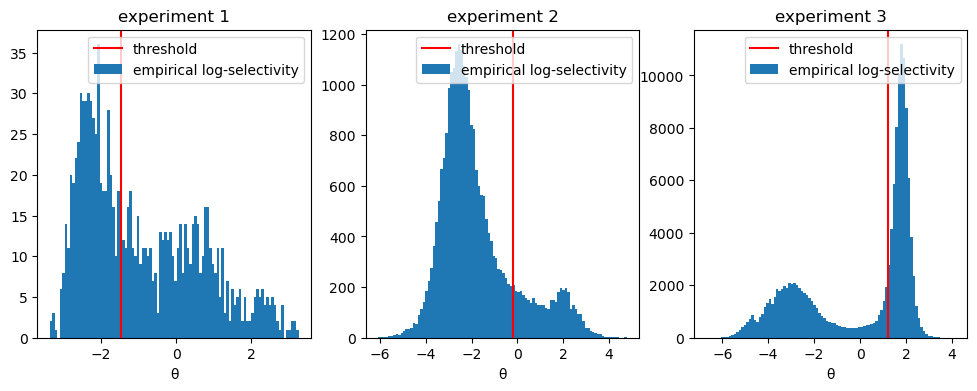

PyObject <matplotlib.legend.Legend object at 0x7f27ed4dbe50>

In [20]:
fig, ax = subplots(1,3, figsize=(12,4))

ax[1].hist(filter(isfinite, θexperiment1), bins=100)
ax[1].axvline(threshold_experiment1, color="red")
ax[1].set_xlabel("θ")
ax[1].set_title("experiment 1")
ax[1].legend(["threshold", "empirical log-selectivity"])

ax[2].hist(filter(isfinite, θexperiment2), bins=100)
ax[2].axvline(threshold_experiment2, color="red")
ax[2].set_xlabel("θ")
ax[2].set_title("experiment 2")
ax[2].legend(["threshold", "empirical log-selectivity"])

ax[3].hist(filter(isfinite, θexperiment3), bins=100)
ax[3].axvline(threshold_experiment3, color="red")
ax[3].set_xlabel("θ")
ax[3].set_title("experiment 3")
ax[3].legend(["threshold", "empirical log-selectivity"])

# CNN

In [21]:
file_cnn = BSON.load("../cnn_models/train_experiment2_thrfit.bson")
model_cnn = file_cnn[:model]
history_cnn = file_cnn[:history]

MVHistory{ValueHistories.History}
  :training_loss => 200 elements {Int64,Float32}

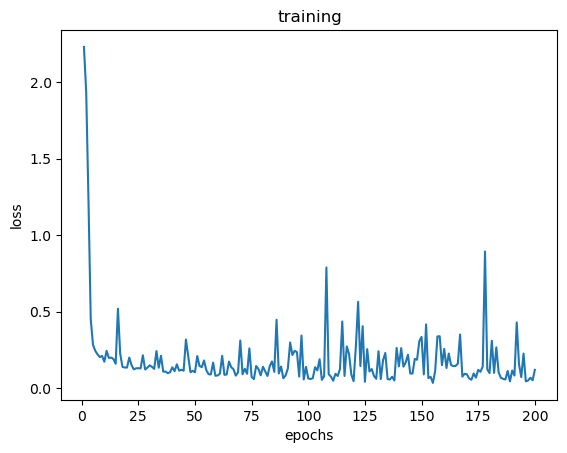

In [22]:
plot(get(history_cnn, :training_loss)...)
title("training")
xlabel("epochs")
ylabel("loss");

In [23]:
logits_experiment1 = model_cnn(sequences_experiment1) |> x -> x[2,:] .- x[1,:];

In [24]:
logits_experiment2 = model_cnn(sequences_experiment2) |> x -> x[2,:] .- x[1,:];

In [25]:
#since this line takes a lot of time you can just load them from the file "logits_experiment3.jld2"
#logits_experiment3 = model_cnn(sequences_experiment3) |> x -> x[2,:] .- x[1,:];
@load "logits_experiment3.jld2"

2-element Vector{Symbol}:
 :logits_experiment3
 :logits_experiment3_notfiltered

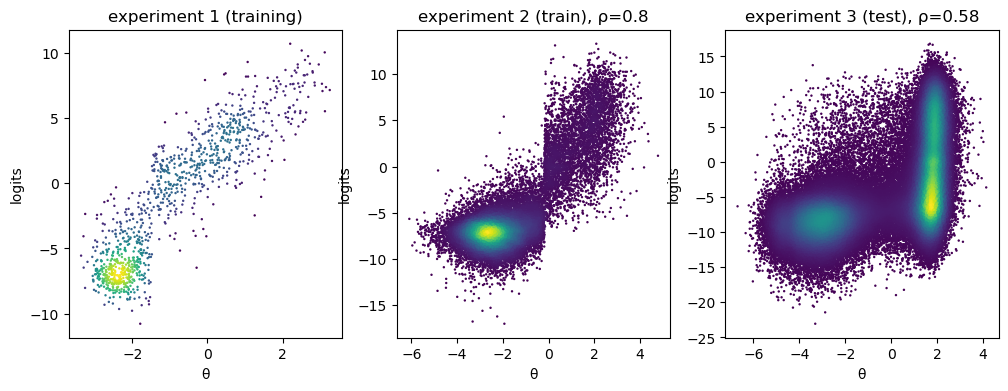

In [26]:
fig, ax = subplots(1,3, figsize=(12,4))

plot_density(θexperiment1, logits_experiment1, ax[1], filter=false)
ax[1].set_title("experiment 1 (training)")
ax[1].set_xlabel("θ")
ax[1].set_ylabel("logits");

plot_density(θexperiment2, logits_experiment2, ax[2], filter=true)
ax[2].set_title("experiment 2 (train), ρ=$(round(cor_sp(θexperiment2, logits_experiment2), digits=2))")
ax[2].set_xlabel("θ")
ax[2].set_ylabel("logits");

plot_density(θexperiment3, logits_experiment3, ax[3], filter=true)
ax[3].set_title("experiment 3 (test), ρ=$(round(cor_sp(θexperiment3, logits_experiment3), digits=2))")
ax[3].set_xlabel("θ")
ax[3].set_ylabel("logits");

In [ ]:
println("training accuracy on experiment 1: ",
compute_accuracy(logits_experiment1, 0.0, θexperiment1, threshold_experiment1))

In [ ]:
println("training accuracy on experiment 2: ",
compute_accuracy(logits_experiment2, 0.0, θexperiment2, threshold_experiment2))

In [27]:
println("testing accuracy on experiment 3: ",
compute_accuracy(logits_experiment3, 0.0, θexperiment3, threshold_experiment3))

testing accuracy on experiment 3: 0.6702504373053458


In [28]:
true_pos_cnn, false_pos_cnn = roc(logits_experiment3, θexperiment3, threshold_experiment3);

In [31]:
auc_val_cnn = auc(false_pos_cnn, true_pos_cnn) |> mean
println("AUC: ", auc_val_cnn)

AUC: 0.8374523213960289


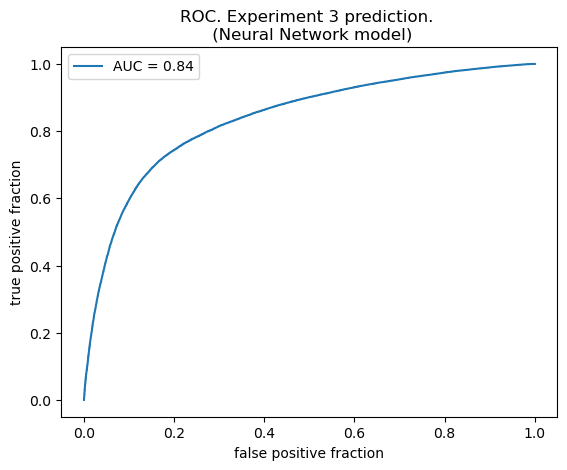

PyObject <matplotlib.legend.Legend object at 0x7f27e4f76730>

In [32]:
plot(false_pos_cnn, true_pos_cnn)
title("ROC. Experiment 3 prediction. \n (Neural Network model)")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["AUC = $(round(auc_val_cnn, digits=2))"])

In [33]:
println("confusion matrix \n")
confusion_matrix(logits_experiment3, 0.0, θexperiment3, threshold_experiment3) 

confusion matrix 

TP: 33386	 FN: 42924
FP: 3450	 TN: 60874

# PhageTree

In [34]:
file_phagetree = BSON.load("../phagetree_models/train_experiment2_b256.bson")
model_pt = file_phagetree[:model]
history_pt = file_phagetree[:history]

MVHistory{ValueHistories.History}
  :loglikelihood_batch => 22000 elements {Int64,Float64}
  :loglikelihood => 200 elements {Int64,Float64}
  :epoch => 22000 elements {Int64,Int64}

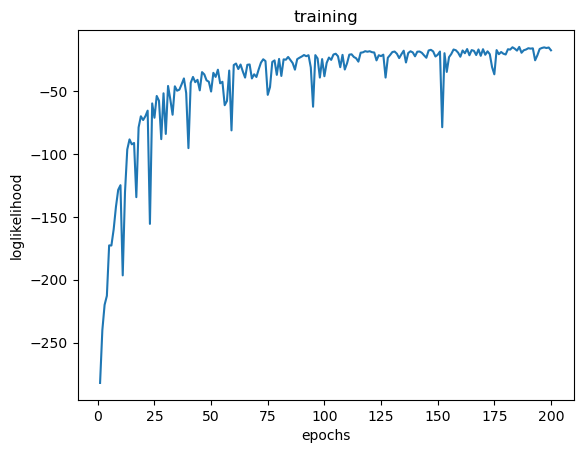

In [35]:
plot(get(history_pt, :loglikelihood)...)
title("training")
xlabel("epochs")
ylabel("loglikelihood");

In [36]:
ls_experiments = vec(log_selectivities(model_pt, data_experiments));

In [37]:
#since the following line takes a lot of time you can just load it from the file "logselectivities_exp3.jld2"
#ls_experiment3 = vec(log_selectivities(model_pt, data_experiment3)[:, 2]);
@load "logselectivities_exp3.jld2"
ls_experiment3_filtered = ls_experiment3[data_experiment3.counts[:, 1].>=100];

In [38]:
θexperiments_pt = vec(log_selectivities(data_experiments));

In [ ]:
#takes a lot of time and it is not useful
#θexperiment3_pt = vec(log_selectivities(data_experiment3));

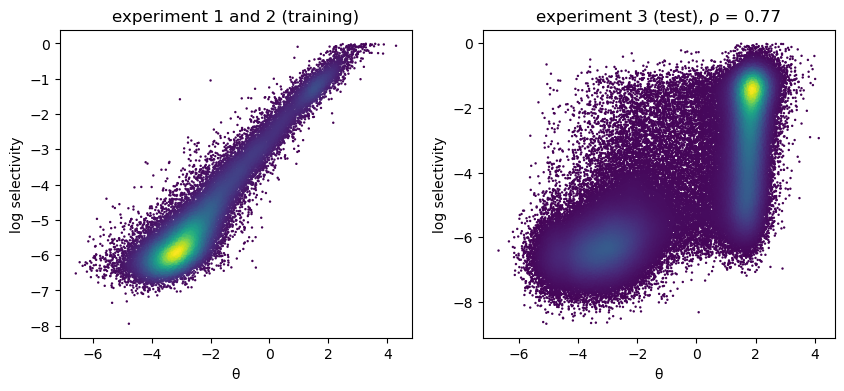

PyObject Text(446.72727272727263, 0.5, 'log selectivity')

In [39]:
fig, ax = subplots(1,2, figsize=(10,4))

plot_density(θexperiments_pt, ls_experiments, ax[1], filter=true)
ax[1].set_title("experiment 1 and 2 (training)")
ax[1].set_xlabel("θ")
ax[1].set_ylabel("log selectivity")

plot_density(θexperiment3, ls_experiment3_filtered, ax[2], filter=true)
ax[2].set_title("experiment 3 (test), ρ = $(round(cor_sp(θexperiment3, ls_experiment3_filtered), digits=2))")
ax[2].set_xlabel("θ")
ax[2].set_ylabel("log selectivity")

In [40]:
true_pos_pt, false_pos_pt = roc(ls_experiment3_filtered, θexperiment3, threshold_experiment3);

In [44]:
auc_val_pt = auc(false_pos_pt, true_pos_pt) |> mean
println("AUC: ", auc_val_pt)

AUC: 0.9035601910117735


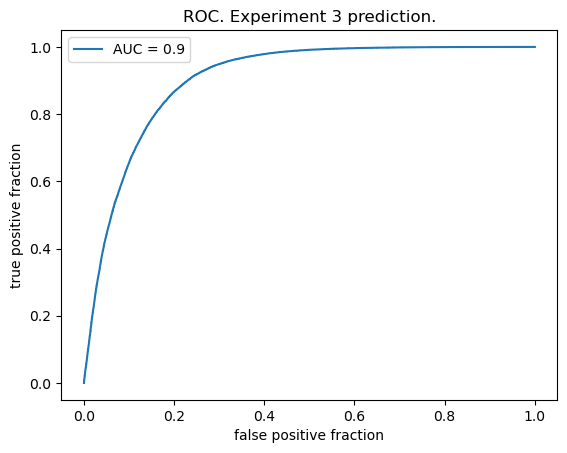

PyObject <matplotlib.legend.Legend object at 0x7f27e4f976a0>

In [45]:
plot(false_pos_pt, true_pos_pt)
title("ROC. Experiment 3 prediction.")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["AUC = $(round(auc_val_pt, digits=2))"])

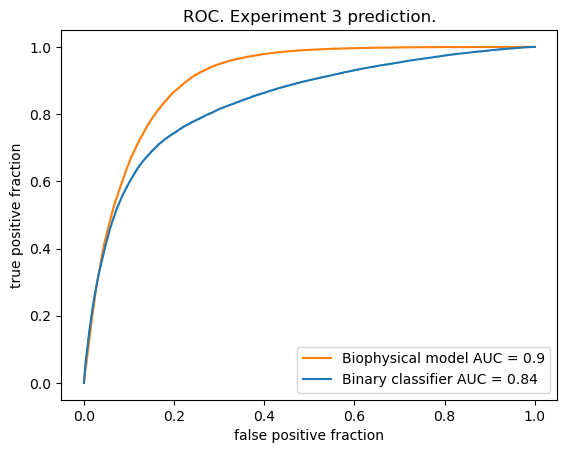

PyObject <matplotlib.legend.Legend object at 0x7f27ed250b80>

In [46]:
plot(false_pos_pt, true_pos_pt, color="#ff7f0e")
plot(false_pos_cnn, true_pos_cnn, color="#1f77b4")
title("ROC. Experiment 3 prediction.")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["Biophysical model AUC = $(round(auc_val_pt, digits=2))", "Binary classifier AUC = $(round(auc_val_cnn, digits=2))"])

In [47]:
ls_threshold = optimal_threshold(ls_experiment3_filtered, true_pos_pt, false_pos_pt)

-4.774115377733081

In [48]:
#uncomment to save data for logos plot (but they are already saved)
#sequences_int_exp3 = onehot2string(sequences_experiment3, channel=true, padding=true)
#sequences_int_exp12 = onehot2string(data_experiments.sequences, channel=false, padding=true)
#@save "logos/data_for_logos.jld2" sequences_int_exp12 sequences_int_exp3 ls_experiment3_filtered ls_threshold θexperiment3 threshold_experiment3

In [51]:
println("testing accuracy on experiment 3: ",
compute_accuracy(ls_experiment3_filtered, ls_threshold, θexperiment3, threshold_experiment3))

testing accuracy on experiment 3: 0.8396902598233713


In [53]:
println("confusion matrix \n")
confusion_matrix(ls_experiment3_filtered, ls_threshold, θexperiment3, threshold_experiment3)

confusion matrix 

TP: 67960	 FN: 8350
FP: 14195	 TN: 50129

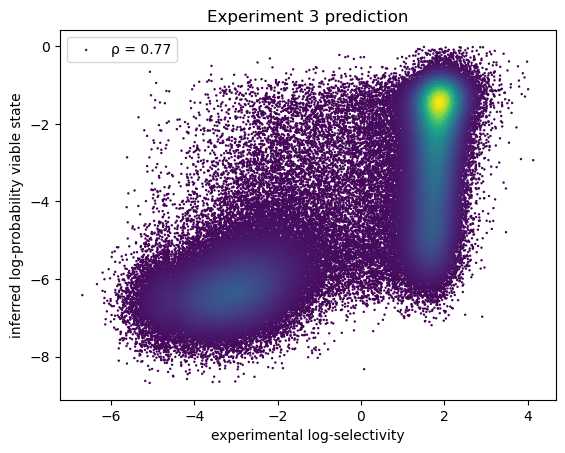

PyObject <matplotlib.legend.Legend object at 0x7f27ecd66100>

In [54]:
plot_density(θexperiment3, ls_experiment3_filtered, filter=true)
title("Experiment 3 prediction")
xlabel("experimental log-selectivity")
ylabel("inferred log-probability viable state")
legend(["ρ = $(round(cor_sp(θexperiment3, ls_experiment3_filtered), digits=2))"])

# Distance analysis

In [55]:
file_exp1 = load("../my_data/data_experiment1.jld2")

Dict{String, Any} with 3 entries:
  "wt_aa"                 => "DEEEIRTTNPVATEQYGSVSTNLQRGNR"
  "sequences_experiment1" => ["DEELIRTTNPVATEQYGSVSTNLQRGNR", "DEEEIYTTNPVATEQY…
  "counts_experiment1"    => [1439 349; 2829 3326; … ; 2053 6849; 4249 409]

In [56]:
wt_aa = file_exp1["wt_aa"]

"DEEEIRTTNPVATEQYGSVSTNLQRGNR"

In [57]:
sequences_string_experiment3 = onehot2string(sequences_experiment3, channel=true, padding=false);

In [58]:
distances = map(x->evaluate(Levenshtein(), x, wt_aa), sequences_string_experiment3);

In [59]:
dmin, dmax = extrema(distances)

(3, 29)

In [61]:
accuracy_distance = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances .== d)
    if length(idx) < 100
        accuracy_distance[i] = NaN
        continue
    end
    accuracy_distance[i] = compute_accuracy(logits_experiment3[idx], 0.0, θexperiment3[idx], threshold_experiment3)
end

In [67]:
accuracy_distance_energy = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances .== d)
    if length(idx) < 100
        accuracy_distance_energy[i] = NaN
        continue
    end
    accuracy_distance_energy[i] = compute_accuracy(ls_experiment3_filtered[idx], ls_threshold, θexperiment3[idx], threshold_experiment3)
end

In [63]:
pearson_distance = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances .== d)
    if length(idx) < 100
        pearson_distance[i] = NaN
        continue
    end
    pearson_distance[i] = cor_sp(θexperiment3[idx], ls_experiment3_filtered[idx])
end

In [64]:
viable_frac = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances .== d)
    if length(idx) < 100
        viable_frac[i] = NaN
        continue
    end
    viable_frac[i] = sum(θexperiment3[idx] .>= threshold_experiment3)/length(idx)
end

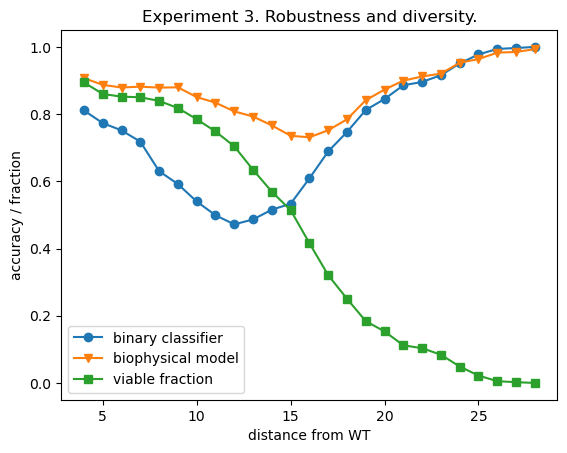

PyObject Text(0.5, 1.0, 'Experiment 3. Robustness and diversity.')

In [68]:
plot(dmin:dmax, accuracy_distance, marker="o", color="#1f77b4")
plot(dmin:dmax, accuracy_distance_energy, marker="v", color="#ff7f0e")
plot(dmin:dmax, viable_frac, marker="s", color="#2ca02c")
legend(["binary classifier", "biophysical model", "viable fraction"])
ylabel("accuracy / fraction")
xlabel("distance from WT")
title("Experiment 3. Robustness and diversity.")

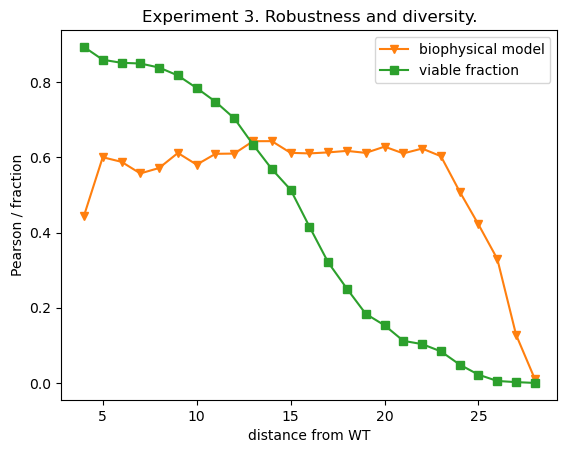

PyObject Text(0.5, 1.0, 'Experiment 3. Robustness and diversity.')

In [69]:
plot(dmin:dmax, pearson_distance, marker="v", color="#ff7f0e")
plot(dmin:dmax, viable_frac, marker="s", color="#2ca02c")
legend(["biophysical model", "viable fraction"])
ylabel("Pearson / fraction")
xlabel("distance from WT")
title("Experiment 3. Robustness and diversity.")